# Setup

In [1]:
%matplotlib inline

import os
import random

from matplotlib import pyplot as plt

import seaborn as sns

import numpy as np
import pandas as pd
import cv2

In [2]:
# display images in grayscale
#matplotlib.rc('image', cmap='gray')

In [3]:
# get the list of filenames in a given directory
camera_view = 'KL11-E1DC'

availible_ids = [int(file.split('.')[0])
                 for file in os.listdir(f"./data/real/{camera_view}/") 
                 if file.endswith(".png")]

print(f'number of unique images: {len(availible_ids)}')
print(f'number of pairs: {len(availible_ids)*len(availible_ids)-1}')

number of unique images: 109
number of pairs: 11880


In [4]:
# some helper functions
def load_img(img_id):
    return cv2.imread(f'data/real/KL11-E1DC/{img_id}.png', 
                      cv2.IMREAD_GRAYSCALE)


def plot_two(img_a, name_a, img_b, name_b):
    plt.figure(1, figsize=(13,13))
    
    plt.subplot(121)
    plt.title(name_a)
    plt.imshow(img_a)

    plt.subplot(122)
    plt.title(name_b)
    plt.imshow(img_b)
    
    plt.show()


def plot_three(imgs, names):
    # there is probably a better way...
    plt.figure(1, figsize=(17,10))
    
    for i in range(3):
        
        plt.subplot(131 + i)
        plt.title(names[i])
        plt.imshow(imgs[i])
    
    plt.show()

    

def map_2_params(img, _operation, x_params, x_param_name, y_params, y_param_name):
    """ 
    Makes a 2D grid of plots by applying the function '_operation' to 'img'
    accross the parameter space defined in the other arguments
    """
    # set up axes
    fig, axs = plt.subplots(nrows=len(x_params), 
                            ncols=len(y_params),
                            sharex='col', sharey='row',
                            figsize=(15,15.4))

    # loop through axes and make each plot
    for i, x_param in enumerate(x_params):        
        for j, y_param in enumerate(y_params):
            
            # plot image with these parameters
            axs[j,i].imshow(_operation(img, x_param, y_param))
            
            # decide whether or not to label axes
            if j == 0:
                axs[j,i].set_title(f'{x_param_name} = {x_param:.2f}')
            if i == 0:
                axs[j,i].set_ylabel((f'{y_param_name} = {y_param:.2f}'), fontsize=12)
            
            # axis tick hiding
            axs[j,i].tick_params(
                bottom=False,
                left=False,
                labelbottom=False,
                labelleft=False)
    
    # title
    fig.text(0.5, 0.92, f'Applying {_operation.__name__}()', ha='center', va='center', fontsize=14)
    
    # global formatting
    fig.subplots_adjust(hspace=0.01, wspace=0.01)

In [5]:
def correct_contrast(img, clip_limit=3, tile_size=7):
    
    # create the object
    clahe = cv2.createCLAHE(clipLimit=clip_limit, 
                            tileGridSize=(tile_size, tile_size))
    
    # apply equalisation
    return clahe.apply(img)
# wrap opencv functions so they are compatible with plots
def bilateral_filter(img, filter_size=5, sigma=70):
    
    # it's not clear exactly what the parameters represent in the docs...
    # (the sigmaSpace parameter appears to be superfluous)
    return cv2.bilateralFilter(img, d=filter_size,
                               sigmaColor=sigma,
                               sigmaSpace=sigma)

def nlm_filter(img, strength=2.5, window_size=6):
    return cv2.fastNlMeansDenoising(img, h=strength, searchWindowSize=window_size)

# [Line Segment Detection](https://docs.opencv.org/3.0-beta/modules/imgproc/doc/feature_detection.html#createlinesegmentdetector)

Start by loading our manually preprocessed image.

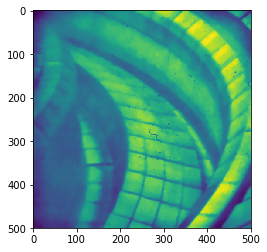

In [6]:
base = cv2.imread(f'./data/real/KL11-E1DC/manual-pp/image.png', cv2.IMREAD_GRAYSCALE)
base_pp = cv2.imread(f'./data/real/KL11-E1DC/manual-pp/image-pp.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(base_pp)

Wrap the opencv LSD code into a function.

In [7]:
def lsd(img, scale=None, sigma_scale=None, return_bin=False, return_lines=False):
    """wrapper for opencv's line segment detection functionality"""
    
    # if we don't specify parameters, leave the defaults
    if scale is None and sigma_scale is None:
        lsd = cv2.createLineSegmentDetector(_refine=cv2.LSD_REFINE_STD)
    
    # otherwise use our settings
    else:
        lsd = cv2.createLineSegmentDetector(_refine=cv2.LSD_REFINE_STD,
                                            _scale=scale,
                                            _sigma_scale=scale)
        
    # detect line segments
    _lines, width, prec, nfa = lsd.detect(img) 
    

    if return_lines:
        # just return a numpy array of line
        return np.squeeze(_lines)
    
    if return_bin:
        # return a binary image of the lines
        bin_lines = np.zeros_like(img)
        bin_lines = lsd.drawSegments(bin_lines, _lines)
        bin_lines = cv2.cvtColor(bin_lines, cv2.COLOR_BGR2GRAY)
        return bin_lines
    
    else:
        # draw lines on top of the preprocessed image
        return lsd.drawSegments(img, _lines)

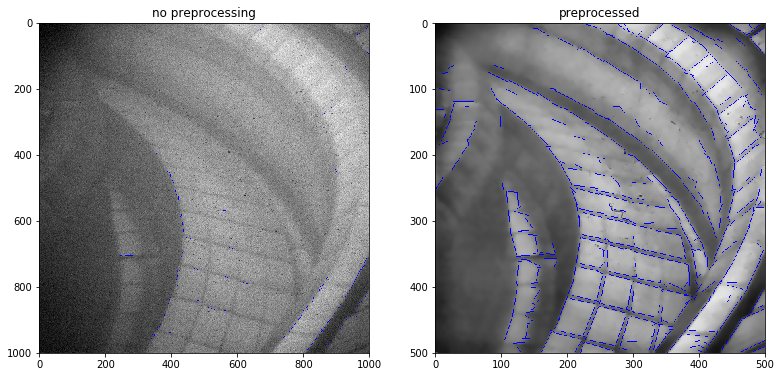

In [8]:
# detect lines
base_lines_img = lsd(base, 0.5, 0.7)
base_pp_lines = lsd(base_pp, 0.7, 0.7)

base_lines = lsd(base_pp,  return_lines=True)

plot_two(base_lines_img, 'no preprocessing', 
         base_pp_lines, 'preprocessed')

# Postprocessing Lines

Once we have our detected line segements there is a wealth of postprocessing options availible.

- Filtering out short lines
- Filtering out lines with 'bad' gradients
- Extend each line segement accross the entire image (or a subsection of it) and then only keep lines that overlap (i.e. are reinforced)
- [Here](https://stackoverflow.com/questions/45531074/how-to-merge-lines-after-houghlinesp) someone very successfully manages to group lines based on the assumption that lines will only be vertical or horizontal. Similar contraints may be possible for our purposes (i.e. the transverse lines are all at rougly the same gradient in the bottom third of the image)
- Use a package that is built for dealing with [shapes and geometry](https://shapely.readthedocs.io/en/latest/)
- A more advanced [clustering approach](https://stackoverflow.com/questions/46406870/python-clustering-hough-lines)
- A [Hough transform](https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_houghlines/py_houghlines.html)

In [9]:
len(base_lines)

410

## Filter Short Segments

In [10]:
def filter_short_lines(lines, min_len=15):
    df = pd.DataFrame(lines, columns=['x1', 'y1', 'x2', 'y2'])
    
    # calculate length and gradients of lines
    df['length'] = np.sqrt((df['x1'] - df['x2'])**2 + (df['y1'] - df['y2'])**2)
    #df['gradient'] = (df['y1'] - df['y2']) / (df['x1'] - df['x2'])
    
    df = df[df['length'] > min_len]
    filtered_lines = df[['x1', 'y1', 'x2', 'y2']].values
    
    return filtered_lines

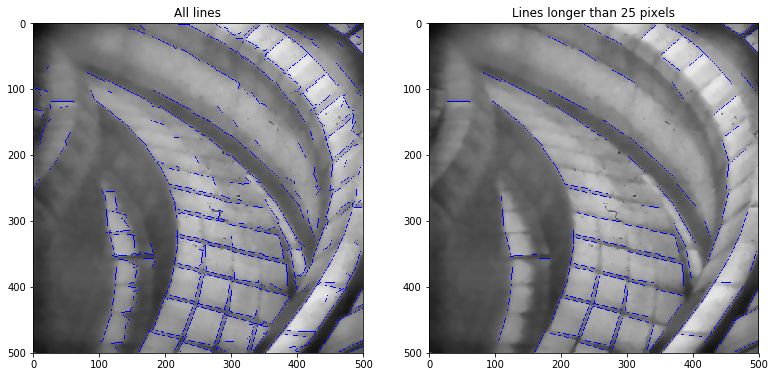

In [11]:
min_length = 25

base_lines_filtered = filter_short_lines(base_lines, min_length)

# draw line segments
lsd_ = cv2.createLineSegmentDetector(_refine=cv2.LSD_REFINE_STD)
base_img_all_lines = lsd_.drawSegments(base_pp, base_lines)
base_img_filtered_lines = lsd_.drawSegments(base_pp, base_lines_filtered)

plot_two(base_img_all_lines, 'All lines', 
         base_img_filtered_lines, f'Lines longer than {min_length} pixels')

## [Probabilistic Hough Transform](https://docs.opencv.org/2.4/modules/imgproc/doc/feature_detection.html#houghlinesp)

Algorithm for joining line segments based on a voting system in slope-intercept space.



In [12]:
# opencv compatibility
def get_lines(lines_in):
    if cv2.__version__ < '3.0':
        return lines_in[0]
    return [l[0] for l in lines_in]


# wrapper
def merge_lines(img, p1, p2, return_lines=False):
    
    merged_lines = cv2.HoughLinesP(img, rho=p1, theta=1*np.pi/180, 
                             threshold=p2, minLineLength=10, 
                             maxLineGap=5)
    
    if return_lines:
        return np.asarray(get_lines(merged_lines))
    
    #img_with_merged_lines = np.copy(contrast_ds_blf_nlm)
    img_with_merged_lines = np.copy(img)

    for line in get_lines(merged_lines):
        leftx, boty, rightx, topy = line
        cv2.line(img_with_merged_lines, (leftx, boty), (rightx,topy), (255, 255, 0), 2)
    
    return img_with_merged_lines

Create a binary image for the Hough transform to work on.

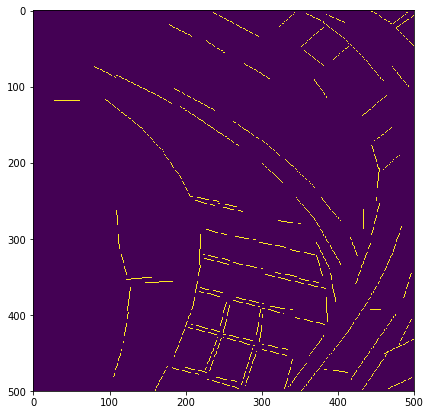

In [13]:
# get a binary image of the filtered line segments
base_img_filtered_lines_only = lsd_.drawSegments(np.zeros_like(base_img_filtered_lines), base_lines_filtered)
base_lines_binary = cv2.cvtColor(base_img_filtered_lines_only, cv2.COLOR_BGR2GRAY)

plt.figure(1, figsize=(7,7))
plt.imshow(base_lines_binary)
plt.show()

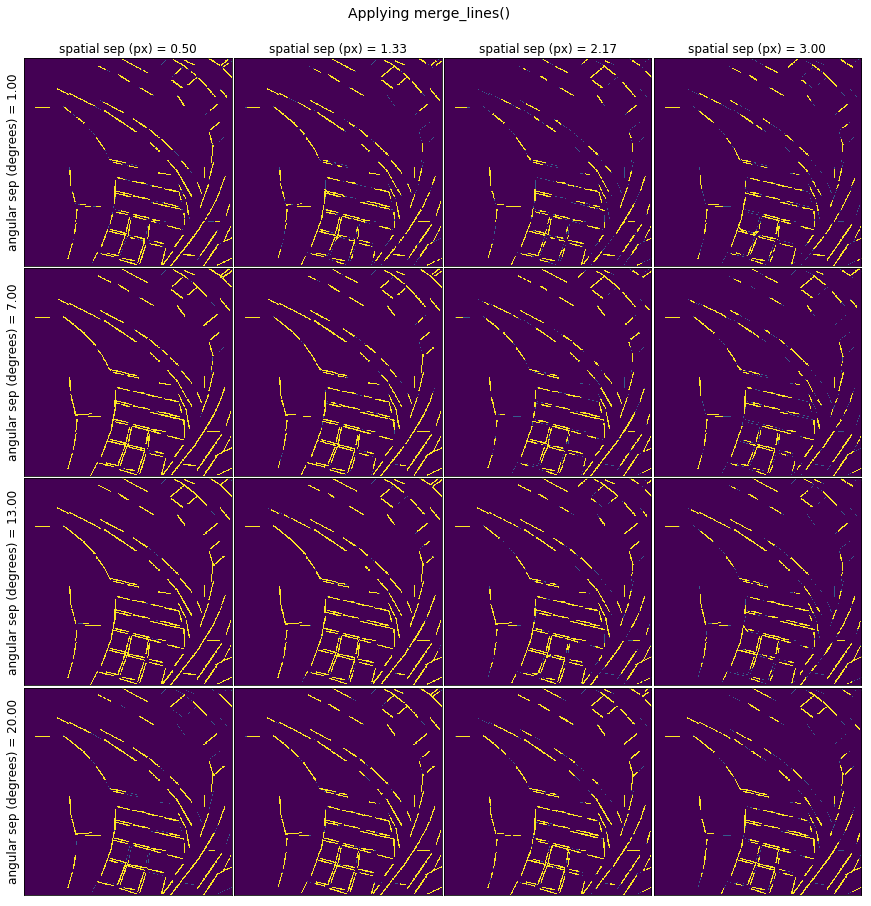

In [14]:
# set parameter space
rhos = np.linspace(0.5, 3, num=4)
thetas = np.linspace(1, 20, num=4).astype(int)

# scan parameter space
map_2_params(base_lines_binary, merge_lines, 
             rhos, 'spatial sep (px)', 
             thetas, 'angular sep (degrees)')

Some thoughts

- we will probably need a different approach to fitting the curved lines. As a first approximating we can assume that circles, when viewed in perspective, will become ellipses, which can be parameterised by three points [see here](http://www.math.utah.edu/~treiberg/Perspect/Perspect.htm#PerspProj)
- once we have intersections how do we know the actual correspondence of points? Maybe we have to hard code that found points will be close to their known position

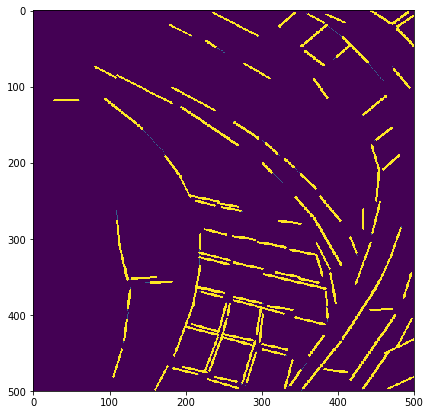

In [15]:
spacial_sep = 1
angular_sep = 13

plt.figure(1, figsize=(7,7))
plt.imshow(merge_lines(base_lines_binary, p1=spacial_sep, p2=angular_sep))
base_lines_merged = merge_lines(base_lines_binary, p1=spacial_sep, p2=angular_sep, return_lines=True)

In [16]:
len(base_lines_merged)

130

## Extend Segments

As line segments often stop before they get a chance to intersect, we will extend them artificially. This is better than finding the intersection between the lines themsevles (i.e. infinitely extended line segments) as we don't want segments in different areas of the image to intersect when they are not close to each other.

Note I have allowed extensions slightly outside the image boundary to temporarily deal with the problem of the top right corner.

In [17]:
def extend_line_segment(line_segment, s=1.5):
    x1, y1, x2, y2 = line_segment
    
    # width and height of the image
    # line segements won't be expanded outside 
    im_size = 510
    
    # calculate expanded points
    Xa = x1*(1 + s)/2 + x2*(1 - s)/2
    Ya = y1*(1 + s)/2 + y2*(1 - s)/2
    
    Xb = x2*(1 + s)/2 + x1*(1 - s)/2
    Yb = y2*(1 + s)/2 + y1*(1 - s)/2
    
    extended = [float(Xa), float(Ya), float(Xb), float(Yb)]
    
    # if any new point is no longer in the image
    if any(i > im_size or i < -10 for i in extended):
        # decrease the extenseion
        new_s = s - 0.1
        if new_s <= 1:
            # return the current line
            return line_segment
        else:
            # try a shorter line extension
            return extend_line_segment(line_segment, s=new_s)
    
    return extended


def extend_line_segments(line_segments, s=1.5):
    # extend line segments (NOTE: this is not vectorised)
    ext_lines = [extend_line_segment(line, s) for line in line_segments]
    
    # combine results and cast to int
    ext_lines = np.asarray(ext_lines).astype(int)
    
    return ext_lines

In [18]:
base_lines_ext = extend_line_segments(base_lines_merged, s=1.7)
len(base_lines_ext)

130

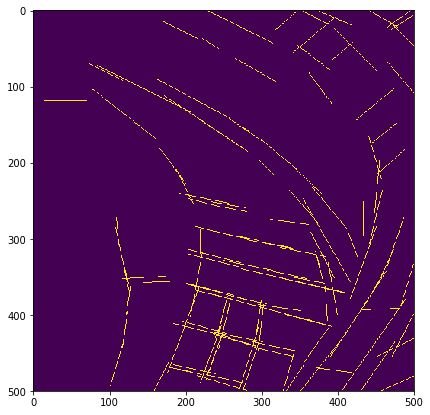

In [19]:
# get a binary image of the filtered line segments
base_ext_lines_img = lsd_.drawSegments(np.zeros_like(base_img_filtered_lines), base_lines_ext)
base_ext_lines_img = cv2.cvtColor(base_ext_lines_img, cv2.COLOR_BGR2GRAY)

plt.figure(1, figsize=(7,7))
plt.imshow(base_ext_lines_img)
plt.show()

## Finding Intersections

In [20]:
from shapely.geometry import LineString

def get_intersections(line_segments):
    """TODO: vectorise"""
    intersections = []

    for line_i in line_segments:
        for line_j in line_segments:
            if not np.array_equal(line_i, line_j):
                line1 = LineString([(line_i[0], line_i[1]), (line_i[2], line_i[3])])
                line2 = LineString([(line_j[0], line_j[1]), (line_j[2], line_j[3])])

                int_ = line1.intersection(line2)
                
                if 'POINT' in str(int_):
                    intersections.append([int(int_.x), int(int_.y)])
                
    return intersections

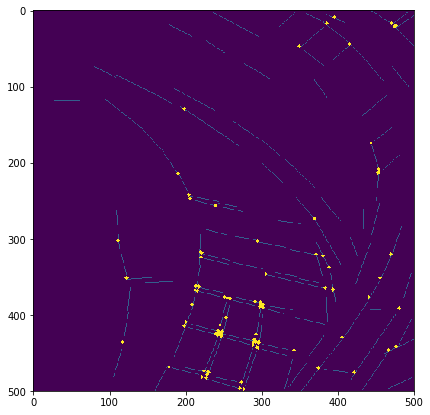

In [21]:
base_intersections = get_intersections(base_lines_ext)

bin_copy = np.copy(base_lines_binary)
for intersection in base_intersections:
    x,y = intersection[0], intersection[1]
    cv2.circle(bin_copy, (x,y), 2, 255, -2)
    
    
plt.figure(1, figsize=(7,7))
plt.imshow(bin_copy)

## Filter & Group Intersections

### Anchors

We can make use of the assumption that any given pixel in one image will not move drastically given any other image. If we know roughly where each key point in the image will end up if it is detected, we can only look for a given key point in a small region around this 'anchor' point. In order to find these anchors without any bias, we determine the position of the anchors from many images overlaid.

First, create our composite image from superimposing all the availible KL11 images we have.

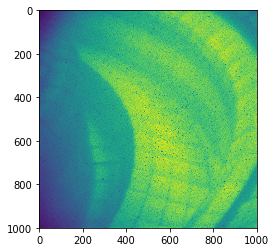

In [22]:
images = [load_img(img_id) for img_id in availible_ids]

composite = np.zeros_like(images[0]).astype('float64')
for img in images:
    composite += img

# normalise the image to [0,255]
composite /= np.max(np.abs(composite))
composite *= (255.0/composite.max())
composite = composite.astype('uint8')
    
plt.imshow(composite)
plt.show()

Then we can do a little bit of preprocessing and save the image, so we can manually add points in Calcam.

In [23]:
# do some manyally determined preprocessing
composite_pp = correct_contrast(composite, 1.67, 20)
composite_pp = nlm_filter(composite_pp, 7.4, 4)

# save the image so it can be imported in Calcam
cv2.imwrite('composite.png', composite_pp)

True

Then, after adding points in Calcam, we can view the anchor points on an arbitrary image.

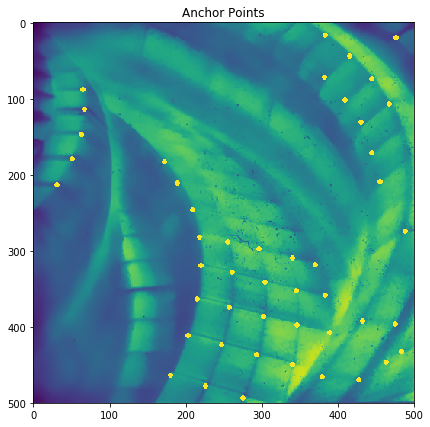

In [24]:
anchors_df = pd.read_csv('calcam/composite-cal/pointpairs.csv', header=1)
anchors = anchors_df[['Image X', 'Image Y']].values / 2 # divide by 2 for downsampling
anchors = anchors.astype(int)

# plot the anchors over some image
comparison_pp = cv2.imread(f'./data/real/KL11-E1DC/manual-pp/91355-pp.png', cv2.IMREAD_GRAYSCALE)
img = np.copy(comparison_pp)

for anchor in anchors:
    x,y = anchor[0], anchor[1]
    cv2.circle(img, (x,y), 2, 255, 2)

    
plt.figure(figsize=(7,7))
plt.title('Anchor Points')
plt.imshow(img)

### Filtering

In [25]:
def filter_intersections(intersections, hardcoded_points, d=10):
    
    # setup DataFrame
    df = pd.DataFrame(intersections, columns=['x', 'y'])
    df.index.name = 'intersection'
    
    # setup distance matrix
    dist_matrix = pd.DataFrame()
    
    # calculate the distance between every intersection
    # and every hardcoded point
    for i, hardcoded_point in enumerate(hardcoded_points):
        dist_matrix[f'dist_to_{i}'] = np.sqrt(((df[['x','y']] - hardcoded_point)**2).sum(axis=1))
    
    # filter points that are far away from hardcoded ones
    close_df = dist_matrix[dist_matrix < d].dropna(how='all')
    
    # associate each intersection with its closest hardcoded point
    close_df['closest'] = close_df.idxmax(axis=1).str.split('_', expand=True)[2]
    
    # return the merged result
    return df.merge(pd.DataFrame(close_df['closest']), left_on=['intersection'], right_index=True)

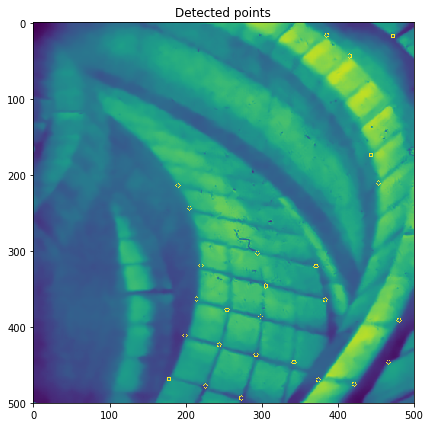

In [26]:
base_points_df = filter_intersections(base_intersections, anchors).groupby('closest').mean().astype(int)
base_points = base_points_df.values

copy1 = np.copy(base_pp)
for intersection in base_points:
    x,y = intersection[0], intersection[1]
    cv2.circle(copy1, (x,y), 3, 255, 1)
    
    
plt.figure(1, figsize=(7,7))
plt.title('Detected points')
plt.imshow(copy1)

## Extend -> Hough  vs Hough -> Extend?

Check if it's better to extend the lines segments straight out of LSD before putting them through the Hough transform.

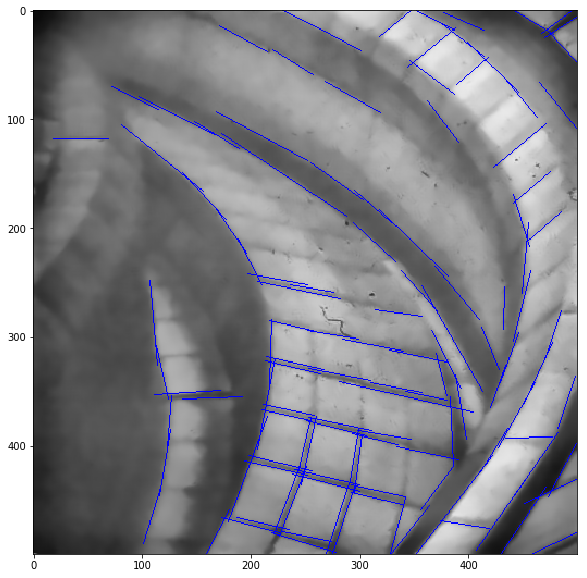

In [27]:
base_lines_filter_no_hough_ext = extend_line_segments(base_lines_filtered)
base_ext_first_lsd = lsd_.drawSegments(base_pp, base_lines_filter_no_hough_ext)
plt.figure(figsize=(10,10))
plt.imshow(base_ext_first_lsd)

In [28]:
# return a binary image of the lines
ext_first_bin_lines = np.zeros_like(base_ext_first_lsd)
ext_first_bin_lines = lsd_.drawSegments(ext_first_bin_lines, base_lines_filter_no_hough_ext)
ext_first_bin_lines = cv2.cvtColor(ext_first_bin_lines, cv2.COLOR_BGR2GRAY)

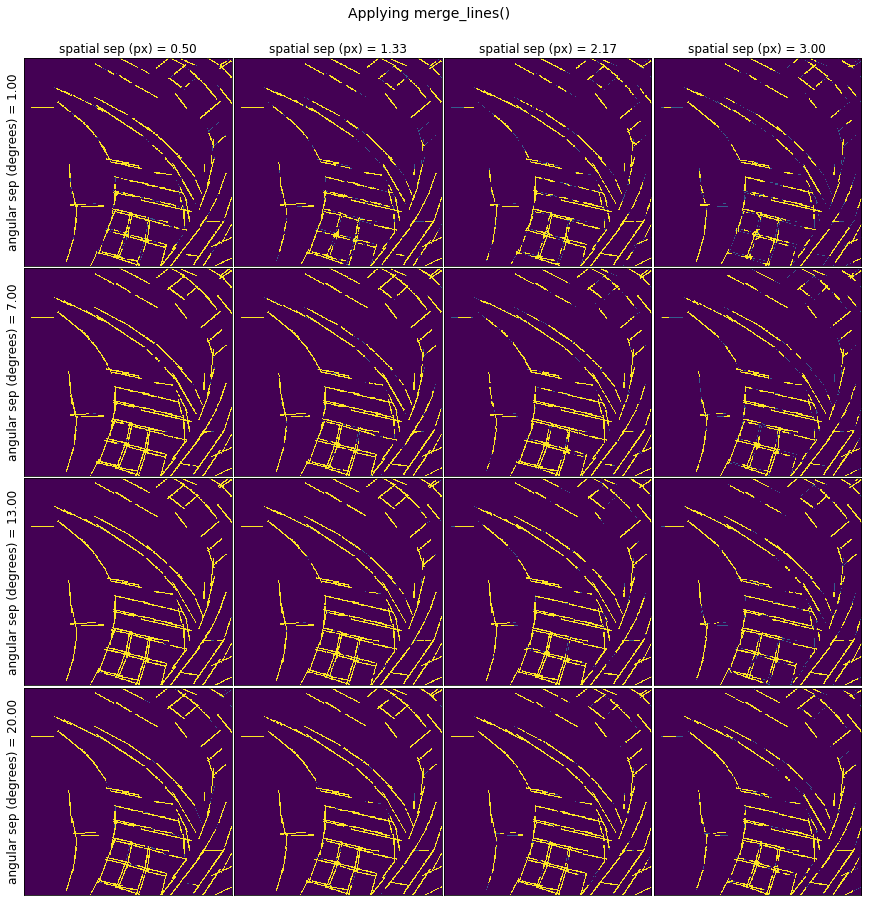

In [29]:
# set parameter space
rhos = np.linspace(0.5, 3, num=4)
thetas = np.linspace(1, 20, num=4).astype(int)

# scan parameter space
map_2_params(ext_first_bin_lines, merge_lines, 
             rhos, 'spatial sep (px)', 
             thetas, 'angular sep (degrees)')

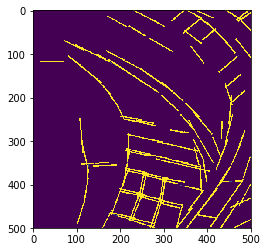

In [30]:
ext_then_merge_lines = merge_lines(ext_first_bin_lines, 0.5, 13)
plt.imshow(ext_then_merge_lines)

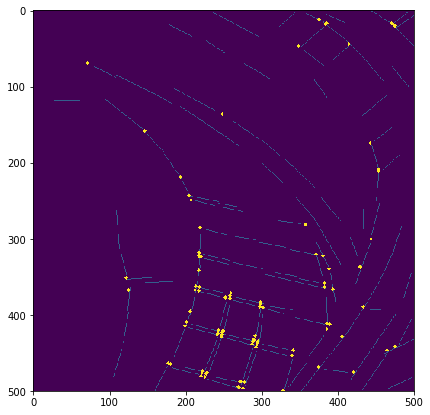

In [31]:
lines_test = merge_lines(ext_first_bin_lines, 0.5, 13, return_lines=True)
lines_test = extend_line_segments(lines_test, s=1.1)

base_intersections_ext_first = get_intersections(lines_test)

bin_copy = np.copy(base_lines_binary)
for intersection in base_intersections_ext_first:
    x,y = intersection[0], intersection[1]
    cv2.circle(bin_copy, (x,y), 2, 255, -2)
    
    
plt.figure(1, figsize=(7,7))
plt.imshow(bin_copy)

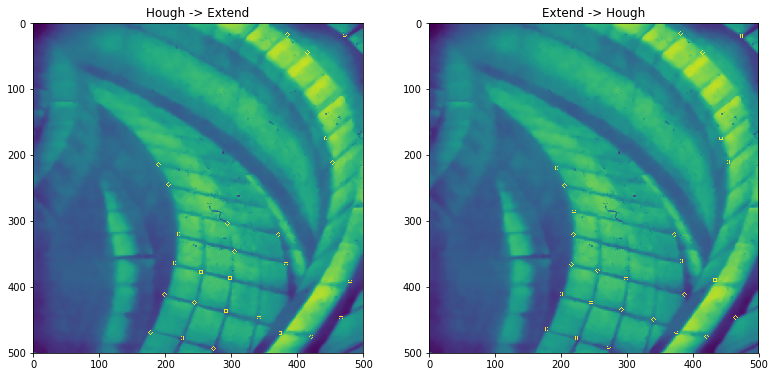

In [32]:
base_points_df_ext_first = filter_intersections(base_intersections_ext_first, anchors, d=10).groupby('closest').mean().astype(int)
base_points_ext_first = base_points_df_ext_first.values

copy2 = np.copy(base_pp)
for intersection in base_points_ext_first:
    x,y = intersection[0], intersection[1]
    cv2.circle(copy2, (x,y), 3, 255, 1)
    
    

plot_two(copy1, 'Hough -> Extend', copy2, 'Extend -> Hough')

Extending first looks like it might be a good idea.

# Comparison image

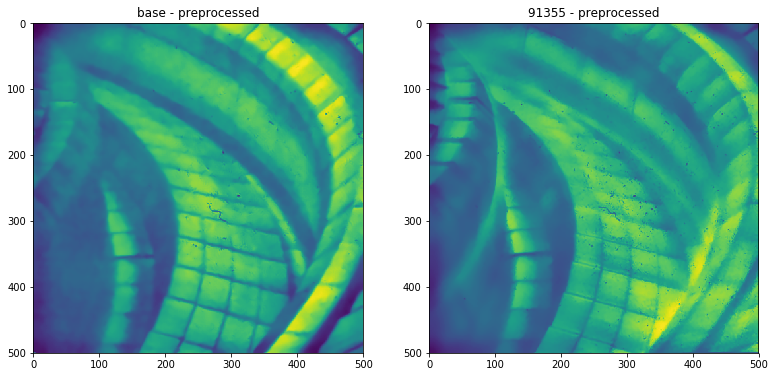

In [33]:
comparison = cv2.imread(f'./data/real/KL11-E1DC/manual-pp/91355.png', cv2.IMREAD_GRAYSCALE)
comparison_pp = cv2.imread(f'./data/real/KL11-E1DC/manual-pp/91355-pp.png', cv2.IMREAD_GRAYSCALE)

plot_two(base_pp, 'base - preprocessed', comparison_pp, '91355 - preprocessed')

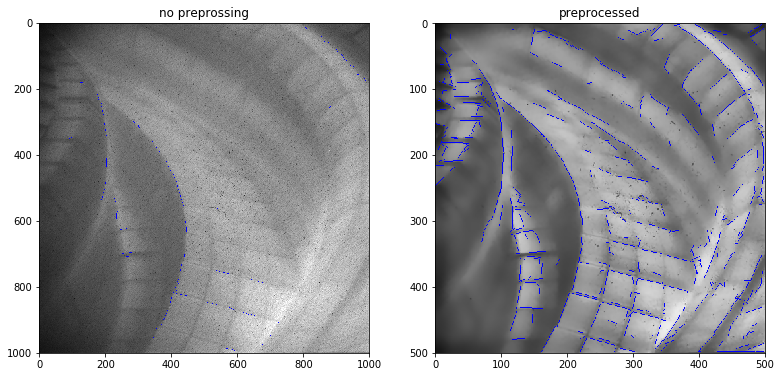

In [34]:
# detect lines
c_ds_lines_img = lsd(comparison, 0.5, 0.7)
c_pp_lines_img = lsd(comparison_pp, 0.8, 0.7)

c_lines = lsd(comparison_pp,  return_lines=True)


plot_two(c_ds_lines_img, 'no preprossing', 
         c_pp_lines_img, 'preprocessed')

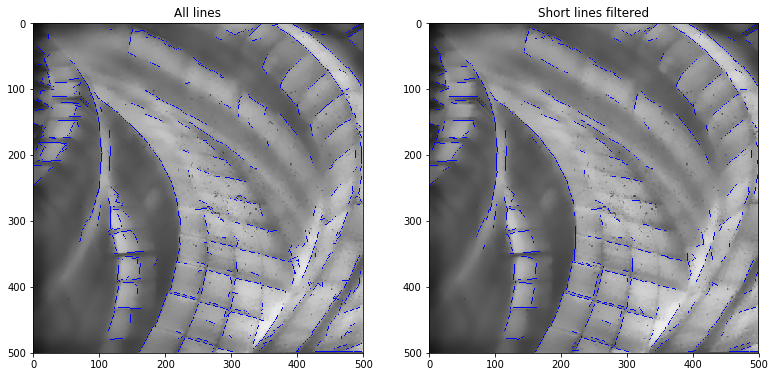

In [35]:
c_lines_filtered = filter_short_lines(c_lines, 10)

# draw line segments
lsd_ = cv2.createLineSegmentDetector(_refine=cv2.LSD_REFINE_STD)
c_pp_lines_img_filtered = lsd_.drawSegments(comparison_pp, c_lines_filtered)

plot_two(c_pp_lines_img, 'All lines', 
         c_pp_lines_img_filtered, 'Short lines filtered')

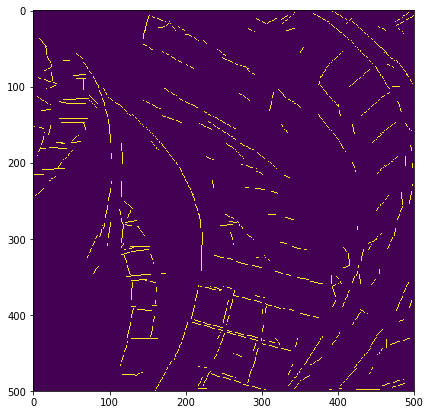

In [36]:
# get a binary image of the filtered line segments
c_img_filtered_lines_only = lsd_.drawSegments(np.zeros_like(c_pp_lines_img_filtered), c_lines_filtered)
c_lines_binary = cv2.cvtColor(c_img_filtered_lines_only, cv2.COLOR_BGR2GRAY)

plt.figure(1, figsize=(7,7))
plt.imshow(c_lines_binary)
plt.show()

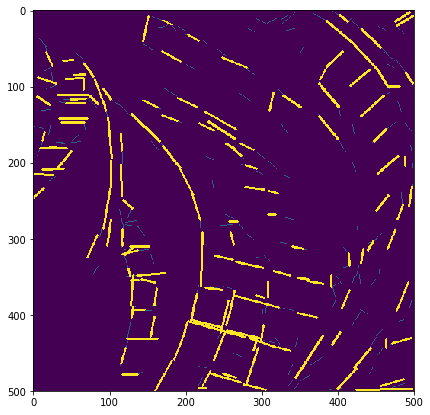

In [37]:
plt.figure(1, figsize=(7,7))
plt.imshow(merge_lines(c_lines_binary, p1=0.5, p2=13))
c_lines_merged = merge_lines(c_lines_binary, p1=0.5, p2=13, return_lines=True)

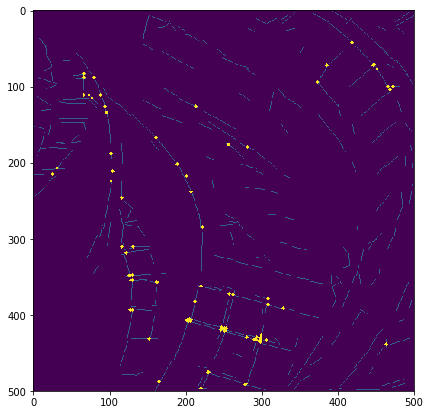

In [38]:
c_lines_ext = extend_line_segments(c_lines_merged, s=2)

c_intersections = get_intersections(c_lines_ext)

bin_copy = np.copy(c_lines_binary)
for intersection in c_intersections:
    x,y = intersection[0], intersection[1]
    cv2.circle(bin_copy, (x,y), 2, 255, -2)
    
    
plt.figure(1, figsize=(7,7))
plt.imshow(bin_copy)

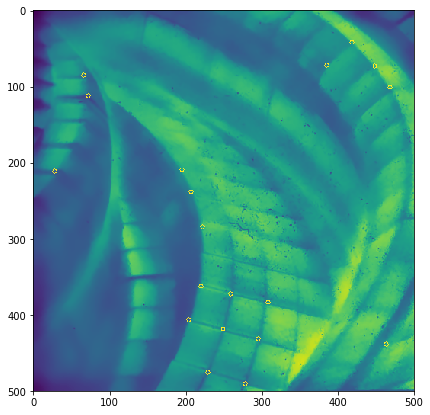

In [39]:
c_points_df = filter_intersections(c_intersections, anchors, d=15).groupby('closest').mean().astype(int)
c_points = c_points_df.values

c_copy = np.copy(comparison_pp)
for intersection in c_points:
    x,y = intersection[0], intersection[1]
    cv2.circle(c_copy, (x,y), 3, 255, 1)
    
    
plt.figure(1, figsize=(7,7))
plt.imshow(c_copy)

# Image [Homographies](https://docs.opencv.org/3.4.1/d9/dab/tutorial_homography.html)

We take the instection of detected points in both images. Looking at the offsets in x and y, we see that there is relatively good consistency of a decrease in x and an increase in y.

In [40]:
diff_df = pd.merge(base_points_df, c_points_df, on='closest', suffixes=('_1', '_2'))

diff_df['x_diff'] = diff_df['x_1'] - diff_df['x_2']
diff_df['y_diff'] = diff_df['y_1'] - diff_df['y_2']

print('Mean offsets are:')
print(diff_df[['x_diff', 'y_diff']].mean())

print('\nOffset stds are:')
print(diff_df[['x_diff', 'y_diff']].std())
diff_df

Mean offsets are:
x_diff   -4.083333
y_diff    4.166667
dtype: float64

Offset stds are:
x_diff    3.028901
y_diff    1.992410
dtype: float64


,x_1,y_1,x_2,y_2,x_diff,y_diff
closest,,,,,,
10,190,214,195,209,-5,5
12,292,436,295,431,-3,5
13,254,377,259,372,-5,5
17,226,477,229,475,-3,2
23,273,493,278,490,-5,3
24,244,423,249,418,-5,5
25,199,411,204,406,-5,5
26,214,363,220,362,-6,1
27,298,386,308,383,-10,3


From here, we can easily pull out corresponding (x,y)'s

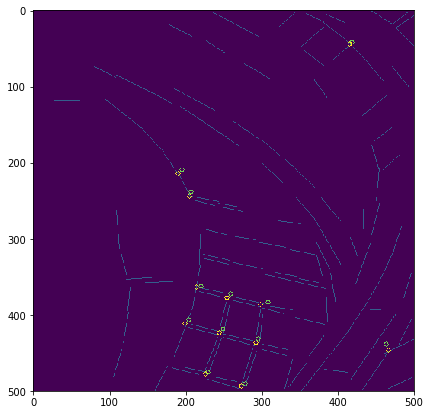

In [41]:
base_tracked_points = diff_df[['x_1', 'y_1']].values
comparions_tracked_points = diff_df[['x_2', 'y_2']].values

base_bin_copy = np.copy(base_lines_binary)
for intersection in base_tracked_points:
    x,y = intersection[0], intersection[1]
    cv2.circle(base_bin_copy, (x,y), 3, 255, 1)
    
for intersection in comparions_tracked_points:
    x,y = intersection[0], intersection[1]
    cv2.circle(base_bin_copy, (x,y), 3, 200, 1)
    
    
plt.figure(1, figsize=(7,7))
plt.imshow(base_bin_copy)

Let's try a homography

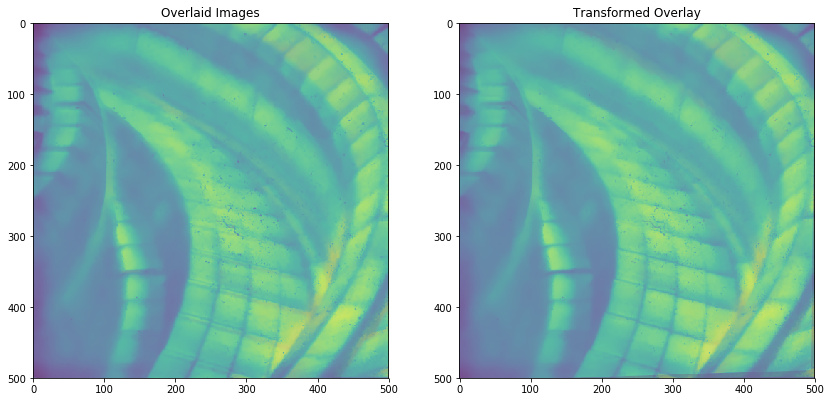

In [42]:
h_matrix, mask = cv2.findHomography(base_tracked_points, comparions_tracked_points)
base_transformed_img = cv2.warpPerspective(base_pp, h_matrix, dsize=base_pp.shape)

plt.figure(1, figsize=(14,14))

plt.subplot(121)
plt.title('Overlaid Images')
plt.imshow(base_pp, alpha=0.5)
plt.imshow(comparison_pp, alpha=0.5)

plt.subplot(122)
plt.title('Transformed Overlay')
plt.imshow(base_transformed_img, alpha=0.5)
plt.imshow(comparison_pp, alpha=0.5)

plt.show()

It looks like a general feature of usining homographiies will be that regions of the image with no point correspondence will be allowed to vary by more than we'd like.

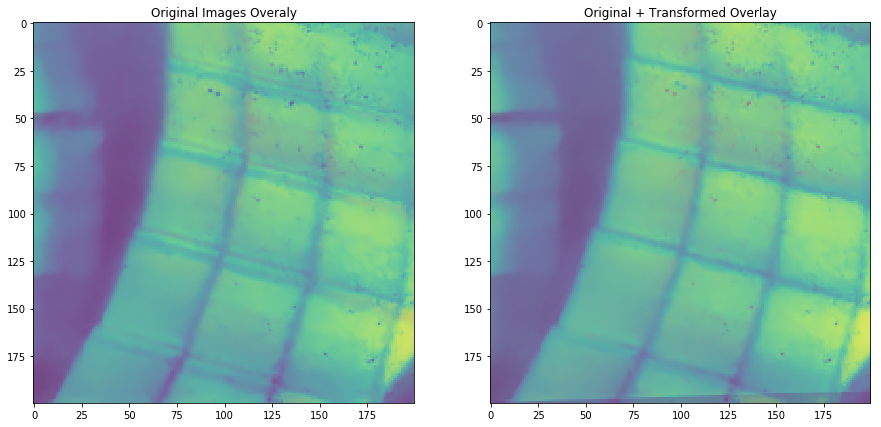

In [43]:
plt.figure(1, figsize=(15,15))

plt.subplot(121)
plt.title('Original Images Overaly')
plt.imshow(base_pp[300:500,150:350], alpha=0.5)
plt.imshow(comparison_pp[300:500,150:350], alpha=0.5)

plt.subplot(122)
plt.title('Original + Transformed Overlay')
plt.imshow(base_transformed_img[300:500,150:350], alpha=0.5)
plt.imshow(comparison_pp[300:500,150:350], alpha=0.5)

plt.show()

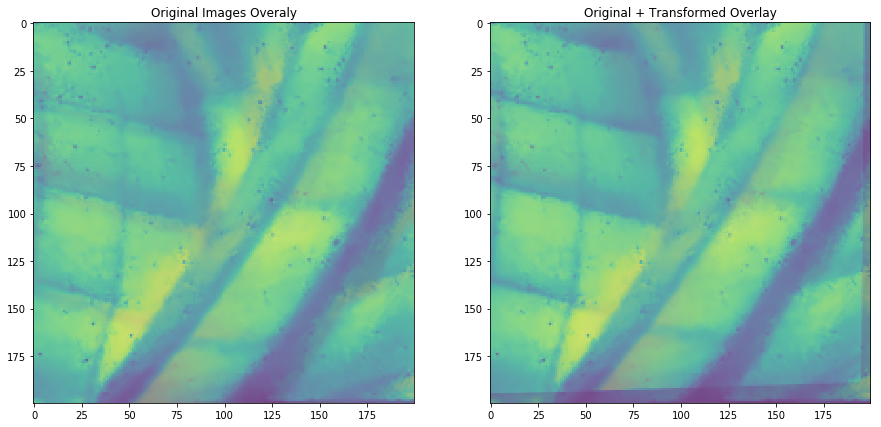

In [44]:
plt.figure(1, figsize=(15,15))

plt.subplot(121)
plt.title('Original Images Overaly')
plt.imshow(base_pp[300:500,300:500], alpha=0.5)
plt.imshow(comparison_pp[300:500,300:500], alpha=0.5)

plt.subplot(122)
plt.title('Original + Transformed Overlay')
plt.imshow(base_transformed_img[300:500,300:500], alpha=0.5)
plt.imshow(comparison_pp[300:500,300:500], alpha=0.5)

plt.show()

Note that as the dirt on the lens is static, we can actually get a sense of how the image has moved by comparing the lens hair between the stabilised shots. This plot is also interesting because the homography works well here even though we have not got many point pairs in the region area.

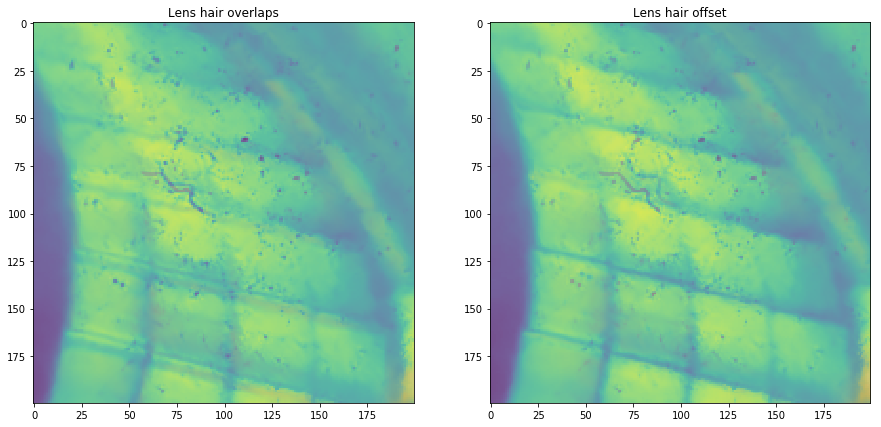

In [45]:
plt.figure(1, figsize=(15,15))

plt.subplot(121)
plt.title('Lens hair overlaps')
plt.imshow(base_pp[200:400,200:400], alpha=0.5)
plt.imshow(comparison_pp[200:400,200:400], alpha=0.5)

plt.subplot(122)
plt.title('Lens hair offset')
plt.imshow(base_transformed_img[200:400,200:400], alpha=0.5)
plt.imshow(comparison_pp[200:400,200:400], alpha=0.5)

plt.show()

Do we actually need the whole image to be fixed, or it is okay to fix some key areas in the images.

# Summary

- Homographies work well in regions of the image pair that are well constrained by point pairs. Outside these regions, homographies can perform poorly.


## Questions
1. We do not actually have true [homographies](https://stackoverflow.com/questions/47465570/opencv-feature-matching-vs-optical-flow) between images because the content of each image does not lie on a plane. Is this limiting us? If so, we may need to use something [more advanced](https://docs.opencv.org/3.2.0/da/de9/tutorial_py_epipolar_geometry.html).
2. If homographies are a reasonable approximation to make, will we be able to generate enough point pairs to constrain them well enough to be useful?